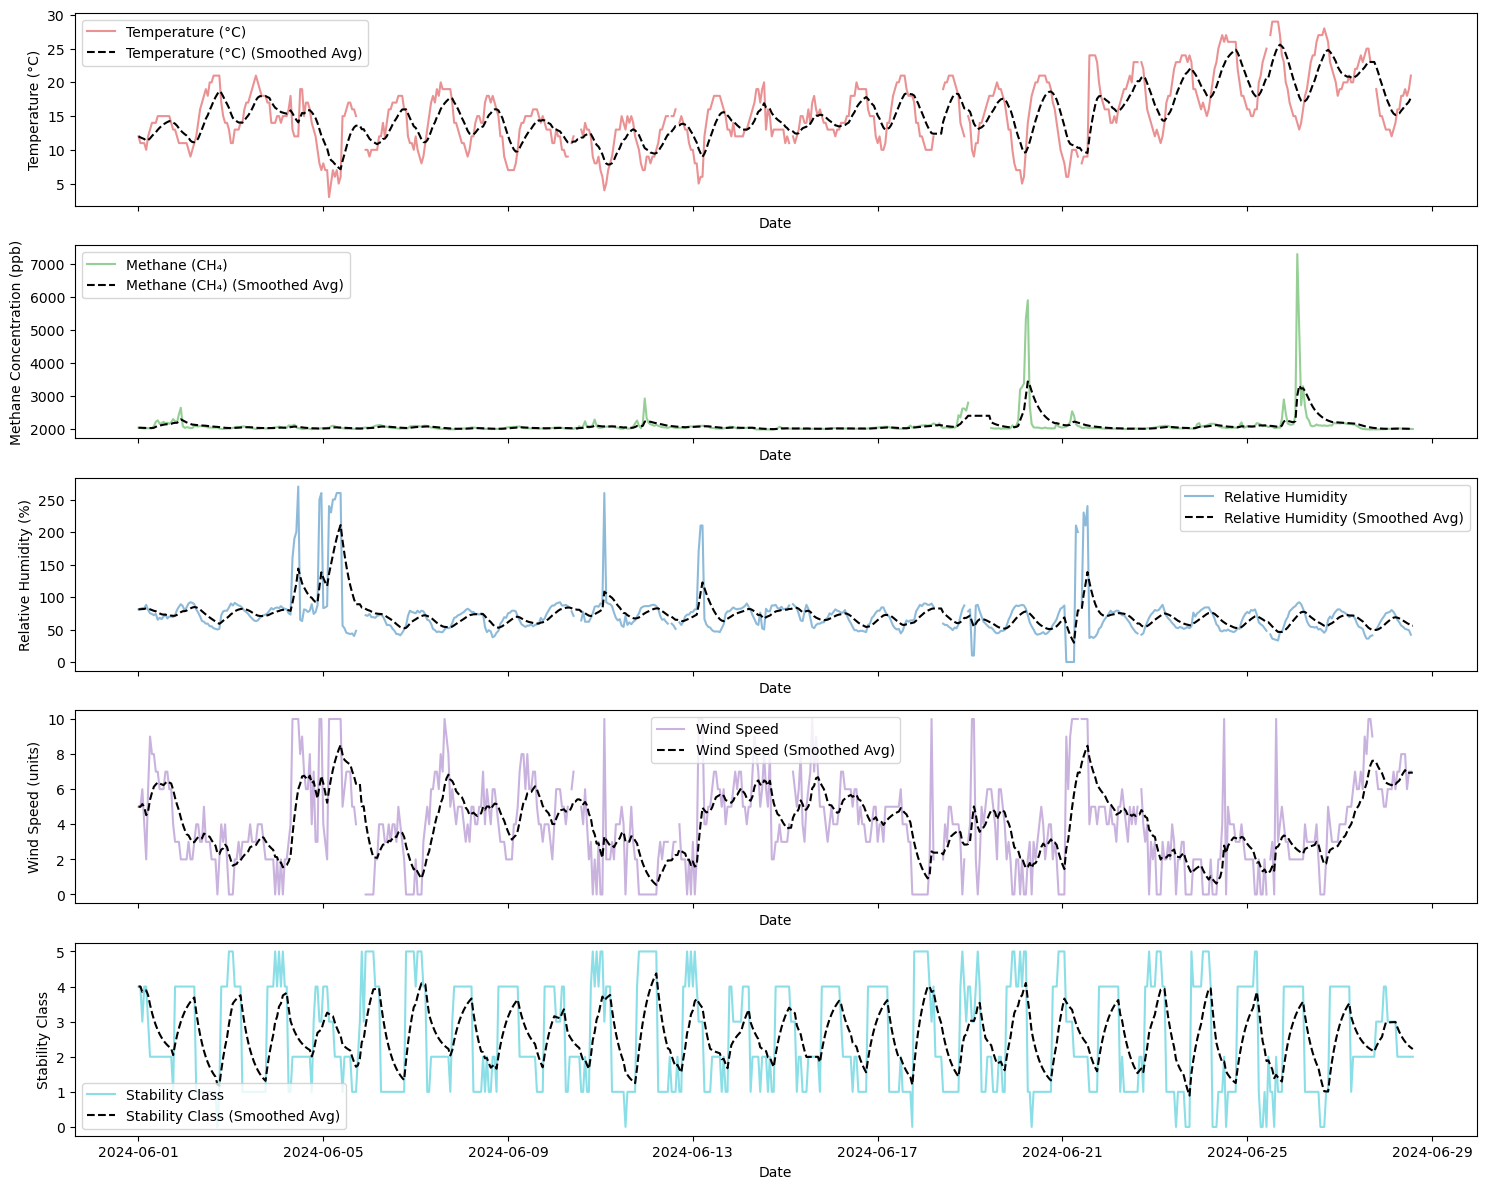

<Figure size 1000x600 with 0 Axes>

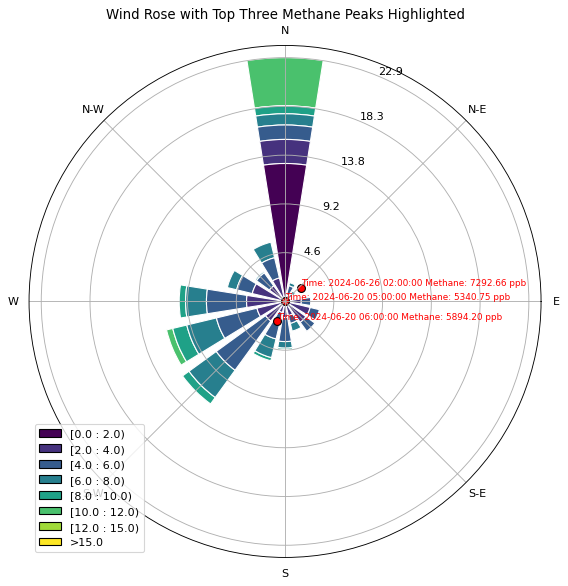

Maximum Methane Concentration: 7292.661169 ppb
Time: 2024-06-26 02:00:00
Wind Speed: 2.0
Wind Direction: 340.0
Pasquill-Gifford Stability Class: E


In [45]:
import matplotlib.pyplot as plt
import pandas as pd
from windrose import WindroseAxes

# Load the dataset
file_path = 'data/msr_ch4_met_hrly_310524_270924.csv'
try:
    data = pd.read_csv(file_path)

    # Convert 'date' column to datetime format
    data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d %H:%M:%S')

    # Filter data to only include June and July 2024
    data = data[(data['date'] >= '2024-06-01') & (data['date'] <= '2024-07-01')]
except FileNotFoundError:
    print(f"Error: The file {file_path} was not found.")
    exit()
except pd.errors.EmptyDataError:
    print(f"Error: The file {file_path} is empty.")
    exit()
except pd.errors.ParserError:
    print(f"Error: The file {file_path} could not be parsed.")
    exit()

# Function to determine Pasquill-Gifford stability class
def determine_stability_class(row):
    hour = row['date'].hour
    wind_speed = row['ws']
    
    if 6 <= hour <= 18:  # Daytime hours (approx. 6 AM to 6 PM)
        if wind_speed < 2:
            return 'A'  # Very Unstable
        elif 2 <= wind_speed <= 5:
            return 'B'  # Moderately Unstable
        else:
            return 'C'  # Slightly Unstable
    else:  # Nighttime hours
        if wind_speed < 2:
            return 'F'  # Stable
        elif 2 <= wind_speed <= 5:
            return 'E'  # Slightly Stable
        else:
            return 'D'  # Neutral

# Apply the function to the dataframe
data['stability_class'] = data.apply(determine_stability_class, axis=1)

# Function to create individual time series subplots with rolling average
def plot_time_series_subplot(ax, x, y, ylabel, label, color, window):
    rolling_avg = y.ewm(span=window, adjust=False).mean()
    ax.plot(x, y, label=label, color=color, alpha=0.5)
    ax.plot(x, rolling_avg, label=f'{label} (Smoothed Avg)', color='black', linestyle='--')
    ax.set_xlabel('Date')
    ax.set_ylabel(ylabel)
    ax.legend()

# Function to create combined time series plots
def plot_combined_time_series(data, window=12):
    fig, axes = plt.subplots(5, 1, figsize=(15, 12), sharex=True)

    # Plot Temperature
    plot_time_series_subplot(axes[0], data['date'], data['temp'], 'Temperature (°C)', 'Temperature (°C)', 'tab:red', window)

    # Plot Methane Concentration
    plot_time_series_subplot(axes[1], data['date'], data['ch4_ppb'], 'Methane Concentration (ppb)', 'Methane (CH₄)', 'tab:green', window)

    # Plot Relative Humidity
    plot_time_series_subplot(axes[2], data['date'], data['rh'], 'Relative Humidity (%)', 'Relative Humidity', 'tab:blue', window)

    # Plot Wind Speed
    plot_time_series_subplot(axes[3], data['date'], data['ws'], 'Wind Speed (units)', 'Wind Speed', 'tab:purple', window)

    # Plot Stability Class
    stability_class_numeric = data['stability_class'].map({'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5})
    plot_time_series_subplot(axes[4], data['date'], stability_class_numeric, 'Stability Class', 'Stability Class', 'tab:cyan', window)

    plt.tight_layout()
    plt.show()

plot_combined_time_series(data)

# Plot Wind Rose Chart with Methane Peaks Highlighted
plt.figure(figsize=(10, 6))
ax = WindroseAxes.from_ax()
custom_bins = [0, 2, 4, 6, 8, 10, 12, 15]
ax.bar(data['wd'], data['ws'], bins=custom_bins, normed=True, opening=0.8, edgecolor='white')

# Highlight the wind direction and speed at the top three methane concentrations
max_methane_rows = data.nlargest(3, 'ch4_ppb')
for idx, row in max_methane_rows.iterrows():
    label = f'Methane Peak {idx + 1}' if idx == 0 else None  # Avoid duplicate labels in the legend
    ax.scatter(row['wd'], row['ws'], color='red', s=50, label=label, edgecolor='black')
    ax.text(row['wd'], row['ws'], f"Time: {row['date']} Methane: {row['ch4_ppb']:.2f} ppb", fontsize=8, color='red', ha='left', va='bottom')

ax.set_title('Wind Rose with Top Three Methane Peaks Highlighted')
ax.set_legend(title='Wind Speed (units)')
plt.legend()
plt.show()

# Find the maximum methane concentration and related data
max_methane_idx = data['ch4_ppb'].idxmax()
max_methane_row = data.loc[max_methane_idx]
max_methane_value = max_methane_row['ch4_ppb']
max_methane_time = max_methane_row['date']
max_methane_ws = max_methane_row['ws']
max_methane_wd = max_methane_row['wd']
max_methane_stability = max_methane_row['stability_class']

print(f"Maximum Methane Concentration: {max_methane_value} ppb")
print(f"Time: {max_methane_time}")
print(f"Wind Speed: {max_methane_ws}")
print(f"Wind Direction: {max_methane_wd}")
print(f"Pasquill-Gifford Stability Class: {max_methane_stability}")


/Users/jamesredman/miniconda3/envs/gaussian_mixing/lib/python3.13/site-packages/cartopy/mpl/geoaxes.py:1646: UserWarning: Log scale: values of z <= 0 have been masked
  result = super().contourf(*args, **kwargs)


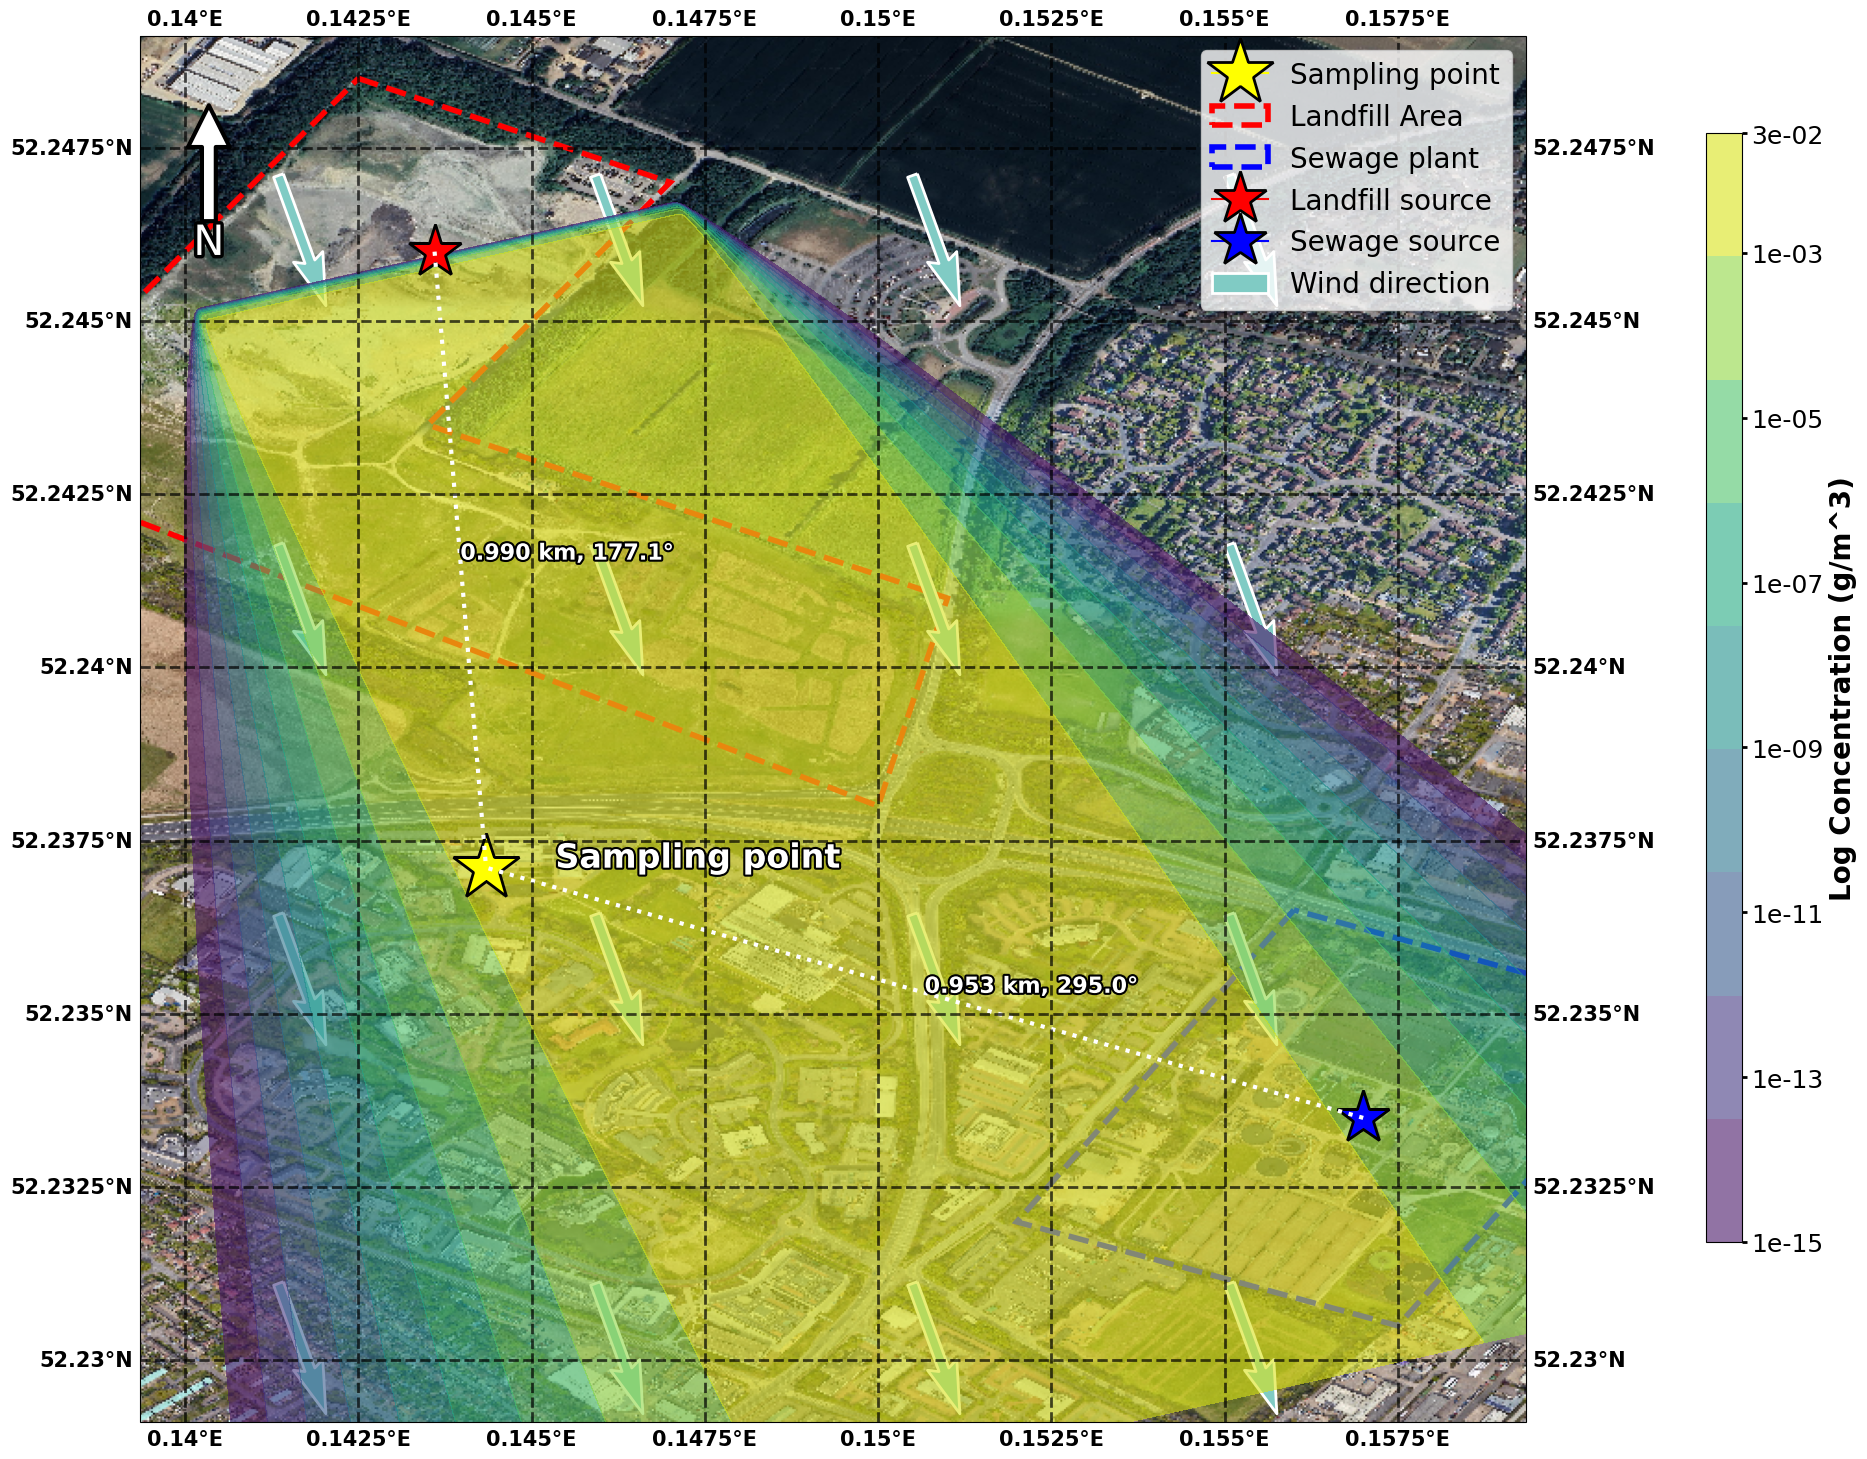

In [46]:
import numpy as np
from matplotlib import pyplot as plt
import flux_maps as maps
import flux_model as model


# Parameters
q = 1.0       # Emission rate in grams per second
u = 2.0       # Wind speed in meters per second
h = 10.0      # Effective stack height in meters
ls = 500.0    # Source width in meters
case = 4     # Atmospheric stability class (0-based index, from 0 to 5)
wind_angle = 340

# Sources, lon and lat
landfill = (0.1436, 52.246)
sewage = (0.157, 52.2335)
sampler = (0.144343, 52.237111)

fig, ax = maps.base_map(landfill, sewage, sampler)

# Adding wind arrows to the map
fig, ax = maps.add_wind_direction(ax, wind_angle)

# Create the coordinate grids
x = np.linspace(0, 2000, 1000)
y = np.linspace(-1000, 1000, 1000)
z = np.linspace(0, 700, 50)
X, Y, Z = np.meshgrid(x, y, z, indexing='ij')

# Compute the concentration data
concentration = model.conc_line(q, u, X, Y, Z, h, ls, case)

fig, ax, plume_data = maps.add_plume_contours(fig, ax, landfill[0], landfill[1], concentration, X, Y, z, theta_deg=wind_angle, z_height=10)

# Show the resulting map with contours
plt.show()


In [47]:
import numpy as np

def find_closest_index(lon_values, lat_values, target_lon, target_lat):
    """
    Finds the index of the coordinate in the lon_values and lat_values arrays that is closest to the target coordinate.

    Parameters:
    lon_values (array-like): Array of longitude values from the mesh grid.
    lat_values (array-like): Array of latitude values from the mesh grid.
    target_lon (float): Longitude of the target coordinate.
    target_lat (float): Latitude of the target coordinate.

    Returns:
    tuple: Index (i, j) of the closest matching coordinate.
    """
    # Convert to numpy arrays
    lon_values = np.array(lon_values)
    lat_values = np.array(lat_values)
    
    # Calculate the distance between each coordinate and the target coordinate
    distances = np.sqrt((lon_values - target_lon)**2 + (lat_values - target_lat)**2)
    
    # Find the index of the minimum distance
    min_index = np.unravel_index(np.argmin(distances), distances.shape)
    
    return min_index

closest_index = find_closest_index(plume_data[0], plume_data[1], sampler[0], sampler[1])

concentration_at_sampler = plume_data[2][closest_index]
print(concentration_at_sampler)

0.0027101165255924006


In [48]:
def g_m3_to_ppm(methane_g_m3, temperature=273.15, pressure=101325):
    # Constants
    MOLAR_MASS_METHANE = 16.04  # g/mol for methane (CH4)
    R = 8.314  # J/(mol*K), ideal gas constant
    
    # Calculate the molar concentration of methane in mol/m^3
    molar_concentration = methane_g_m3 / MOLAR_MASS_METHANE  # mol/m^3
    
    # Calculate volume at specified conditions (temperature in Kelvin, pressure in Pascals)
    molar_volume = R * temperature / pressure  # in m^3/mol (ideal gas law)
    
    # Convert molar concentration to ppm
    ppm = molar_concentration / molar_volume * 1e6
    
    return ppm

# Example usage
ppm_value = g_m3_to_ppm(concentration_at_sampler)
print(f"Methane concentration: {ppm_value:.2f} ppm")


Methane concentration: 7538.57 ppm


In [ ]:
change